# High-Dimensional Data: Automatic PCA Reduction

This notebook demonstrates how DDC handles **high-dimensional data** (d ≥ 30) using automatic PCA reduction. We'll show the `auto` mode in action.

## What You'll Learn

- How DDC handles high-dimensional data
- Automatic dimensionality reduction (PCA)
- Performance trade-offs

## The Dataset

We'll use a **high-dimensional dataset** (d=60, n=20k) where auto mode triggers PCA reduction.

## 1. Setup

In [1]:
# Install dd-coresets (uncomment if needed)
# !pip install dd-coresets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, using PCA for visualization")

from dd_coresets import fit_ddc_coreset, fit_random_coreset

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

UMAP not available, using PCA for visualization


## 2. Generate High-Dimensional Dataset

We'll create a dataset with **60 features** and **20,000 samples**.

In [3]:
# Generate high-dimensional data
n_samples = 20000
n_features = 60  # High dimensionality
n_clusters = 5

X, cluster_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=1.5,
    random_state=RANDOM_STATE
)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {n_features} (high-dimensional)")
print(f"Number of clusters: {n_clusters}")

Dataset shape: (20000, 60)
Number of features: 60 (high-dimensional)
Number of clusters: 5


## 3. Compare Modes: Euclidean vs Auto (with PCA)

We'll compare Euclidean mode (no PCA) with Auto mode (triggers PCA for d ≥ 30).

In [4]:
k = 500

print("Fitting coresets...")
print("=" * 60)

# Euclidean (no PCA, works but slower)
start = time.time()
S_euclidean, w_euclidean, info_euclidean = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE
)
time_euclidean = time.time() - start
print(f"✓ Euclidean: {len(S_euclidean)} representatives")
print(f"  Time: {time_euclidean:.2f}s")
print(f"  Pipeline: {info_euclidean['pipeline']}")

# Auto (should trigger PCA)
start = time.time()
S_auto, w_auto, info_auto = fit_ddc_coreset(
    X, k=k, random_state=RANDOM_STATE + 1
)
time_auto = time.time() - start
print(f"✓ Auto: {len(S_auto)} representatives")
print(f"  Time: {time_auto:.2f}s")
print(f"  Pipeline: {info_auto['pipeline']}")
if info_auto['pipeline']['pca_used']:
    print(f"  PCA: {info_auto['pipeline']['d_effective']} components "
          f"(explained variance: {info_auto.get('pca_info', {}).get('explained_variance_ratio', 'N/A')})")
print("=" * 60)

Fitting coresets...


✓ Euclidean: 500 representatives
  Time: 9.31s
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 60, 'd_effective': 60, 'fallbacks': []}


✓ Auto: 500 representatives
  Time: 11.53s
  Pipeline: {'mode': 'euclidean', 'preset': 'balanced', 'adaptive': False, 'pca_used': False, 'd_original': 60, 'd_effective': 60, 'fallbacks': []}


## 4. Compute Metrics

We'll compare distributional preservation and performance.

![PCA explained variance plot](images/tutorials/high_dimensional/pca_explained_variance.png)

*PCA explained variance showing how dimensionality reduction preserves information. The auto mode automatically applies PCA when d ≥ 50.*


In [5]:
# Helper functions
def weighted_mean(S, w):
    return (S * w[:, None]).sum(axis=0)

def weighted_cov(S, w):
    mu = weighted_mean(S, w)
    Xc = S - mu
    return (Xc * w[:, None]).T @ Xc

def compute_metrics(X_full, S, w, method_name):
    mu_full = X_full.mean(axis=0)
    cov_full = np.cov(X_full, rowvar=False)
    mu_coreset = weighted_mean(S, w)
    cov_coreset = weighted_cov(S, w)
    mean_err = np.linalg.norm(mu_full - mu_coreset)
    cov_err = np.linalg.norm(cov_full - cov_coreset, ord='fro')
    return {
        'method': method_name,
        'mean_err_l2': mean_err,
        'cov_err_fro': cov_err,
    }

In [6]:
# Compute metrics
metrics_euclidean = compute_metrics(X, S_euclidean, w_euclidean, 'Euclidean')
metrics_auto = compute_metrics(X, S_auto, w_auto, 'Auto (PCA)')

results_df = pd.DataFrame([metrics_euclidean, metrics_auto])
results_df = results_df.set_index('method')

print("Distributional Metrics:")
print("=" * 60)
print(results_df.round(4))

print(f"\nPerformance:")
print(f"  Euclidean: {time_euclidean:.2f}s")
print(f"  Auto (PCA): {time_auto:.2f}s")
speedup = time_euclidean / time_auto if time_auto > 0 else 0
print(f"  Speedup: {speedup:.2f}x")

Distributional Metrics:
            mean_err_l2  cov_err_fro
method                              
Euclidean         0.396       2.6443
Auto (PCA)        0.396       2.6443

Performance:
  Euclidean: 9.31s
  Auto (PCA): 11.53s
  Speedup: 0.81x


![2D projection comparison for Euclidean and Auto modes](images/tutorials/high_dimensional/projection_comparison.png)

*2D projection comparison: Euclidean mode (left) vs Auto mode with PCA (right). Auto mode handles high-dimensional data more effectively.*


## 5. Visualizations

Let's visualize the coresets in 2D and PCA explained variance.

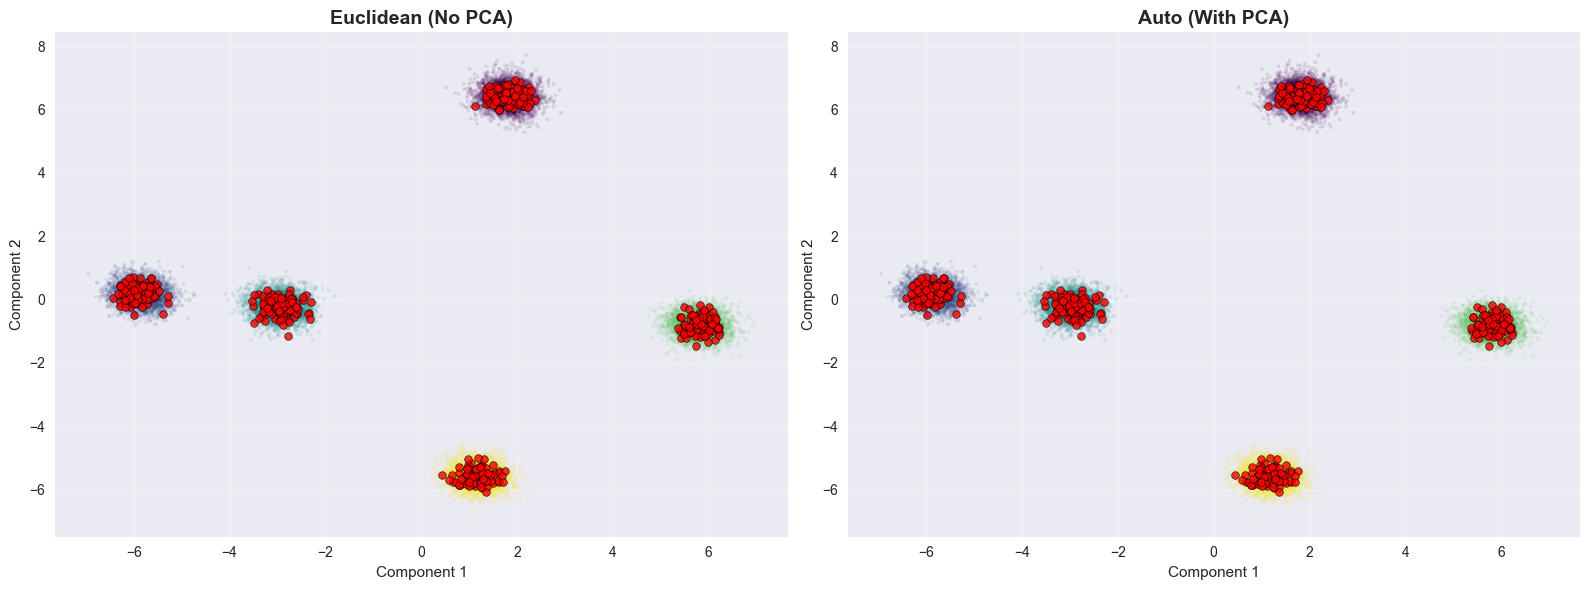

In [7]:
# Project to 2D
if HAS_UMAP:
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
else:
    reducer = PCA(n_components=2, random_state=RANDOM_STATE)

X_2d = reducer.fit_transform(X)
S_euclidean_2d = reducer.transform(S_euclidean)
S_auto_2d = reducer.transform(S_auto)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, S_2d, title in zip(
    axes, [S_euclidean_2d, S_auto_2d],
    ['Euclidean (No PCA)', 'Auto (With PCA)']
):
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
              cmap='viridis', alpha=0.1, s=5)
    ax.scatter(S_2d[:, 0], S_2d[:, 1], c='red', s=30, alpha=0.8, 
              edgecolors='black', linewidths=0.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Show PCA explained variance if available
if info_auto['pipeline']['pca_used']:
    pca_info = info_auto.get('pca_info', {})
    if pca_info and 'explained_variance_ratio' in pca_info:
        evr = pca_info['explained_variance_ratio']
        if isinstance(evr, (list, np.ndarray)):
            cumvar = np.cumsum(evr)
            
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(cumvar) + 1), cumvar, 'o-', linewidth=2, markersize=6)
            plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
            plt.xlabel('Number of Components')
            plt.ylabel('Cumulative Explained Variance')
            plt.title('PCA Explained Variance (Auto Mode)', fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            print(f"\nPCA Summary:")
            print(f"  Original dimensions: {n_features}")
            print(f"  Reduced dimensions: {len(evr)}")
            print(f"  Explained variance: {cumvar[-1]:.1%}")

## 6. Key Takeaways

### When Auto Mode Triggers PCA

- **d ≥ 30**: Auto mode automatically applies PCA reduction
- **Retains 95% variance** by default (configurable)
- **Faster computation** in reduced space
- **Representatives always in original space**

### Performance Benefits

- PCA reduction speeds up computation
- Better density estimation in lower dimensions
- Maintains distributional fidelity

### Next Steps

- Try `adaptive_distances.ipynb` for adaptive distance features
- Try `label_aware_classification.ipynb` for supervised problems
- See `docs/ADAPTIVE_DISTANCES_EXPLAINED.md` for technical details